## Standardize molecules

In [35]:
import pandas as pd
import numpy as np
import random
from rdkit.Chem import AllChem
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdkit import RDLogger
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.rdinchi import MolToInchiKey

from standardizer.CustomStandardizer import CustomStandardizer
from loaders.Loaders import CSVLoader

from copy import deepcopy

RDLogger.DisableLog('rdApp.*')

seed_value = 123

np.random.seed(seed_value)
random.seed(seed_value)

## Standardize sweet, bitter, and tasteless compounds

In [3]:



def standardize(dataset_file_path, label):
    
    loader = CSVLoader(dataset_file_path,
                       id_field = "id",
                       mols_field='smiles',
                       labels_fields=label)

    dataset_to_test = loader.create_dataset()

    standardisation_params = {
        'REMOVE_ISOTOPE': True,
        'NEUTRALISE_CHARGE': True,
        'REMOVE_STEREO': False,
        'KEEP_BIGGEST': True,
        'ADD_HYDROGEN': False,
        'KEKULIZE': True,
        'NEUTRALISE_CHARGE_LATE': True}
    
    CustomStandardizer(params = standardisation_params).standardize(dataset_to_test)
    
    return dataset_to_test

# Standardize sweet and the rest of the database
sweetness_dataset = standardize("../data_test/sweeteness_dataset_v3_1.csv", "sweet")
# Save clean compounds
sweetness_dataset.save_to_csv("../data_test/clean_sweeteness_dataset_v3_1.csv")
# Standardize bitter molecules
bitter_molecules = standardize("../data_test/bitter_molecules.csv", "bitter")
# Save clean bitter molecules
bitter_molecules.save_to_csv("../data_test/clean_bitter_molecules.csv")


Standardizing datapoint 0
Standardizing datapoint 1000
Standardizing datapoint 2000
Standardizing datapoint 3000
Standardizing datapoint 4000
Standardizing datapoint 5000
Standardizing datapoint 6000
Standardizing datapoint 7000
Standardizing datapoint 8000
Standardizing datapoint 9000
Standardizing datapoint 10000
Standardizing datapoint 11000
Standardizing datapoint 12000
Standardizing datapoint 13000
Standardizing datapoint 14000
Standardizing datapoint 15000
Standardizing datapoint 16000
Standardizing datapoint 17000
Standardizing datapoint 18000
Standardizing datapoint 19000
Standardizing datapoint 20000
Standardizing datapoint 21000
Standardizing datapoint 22000
Standardizing datapoint 23000
Standardizing datapoint 24000
Standardizing datapoint 25000
Standardizing datapoint 26000
Standardizing datapoint 27000
Standardizing datapoint 28000
Standardizing datapoint 29000
Standardizing datapoint 30000
Standardizing datapoint 31000
Standardizing datapoint 32000
Standardizing datapoint

## Drop duplicates and remove non-convertable molecules

In [19]:
sweeteners = pd.read_csv("../data_test/clean_sweeteness_dataset_v3_1.csv")
bitter = pd.read_csv("../data_test/clean_bitter_molecules.csv")

In [20]:
print(sweeteners.shape)
print(bitter.shape)

(78848, 3)
(1141, 3)


In [21]:
from copy import copy

def remove_not_convertable_molecules(dataset, structure_column):
    new_dataset = copy(dataset)
    for i, row in dataset.iterrows():
        structure = row[structure_column]

        try:
            mol = MolFromSmiles(structure)
            if mol is None:
                new_dataset = new_dataset.drop(i)

        except:
            new_dataset = new_dataset.drop(i)

    return new_dataset

In [22]:
bitter = bitter.drop_duplicates(subset ="mols",
                     keep = False, inplace = False)

In [23]:
bitter = remove_not_convertable_molecules(bitter, "mols")

In [24]:
sweeteners = sweeteners.drop_duplicates(subset ="mols",
                     keep = False, inplace = False)

In [25]:
sweeteners = remove_not_convertable_molecules(sweeteners, "mols")

In [26]:
print(sweeteners.shape)
print(bitter.shape)

(76764, 3)
(1065, 3)


In [148]:
# save the clean molecules without duplicates and without non-convertable molecules
bitter.to_csv("clean_bitter_molecules.csv", index=False)
sweeteners.to_csv("clean_sweeteness_dataset_v3_1.csv", index=False)

## Function to generate similarities for data visualization

In [28]:
def generate_similarities(smiles):
    fps = []
    similarities_list = []
    for smiles in smiles:
        fp = AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(smiles), 2, 2048)
        #fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(MolFromSmiles(smiles), 
                                                                    #nBits=2048, includeChirality = True)
        fps.append(fp)
    
    if len(fps) > 10000:
        entries = 10000
    else:
        entries = len(fps)
        
    for i in range(0,entries):
        
        remaining_fp = fps[:i] + fps[i+1:]
        similarities = DataStructs.BulkTanimotoSimilarity(fps[i], remaining_fp)
        similarities.insert(i,1)
        similarities_list.append(similarities)
        
    return np.transpose(np.array(similarities_list))

## Sample negative cases and force bitter molecules to be in the dataset

In [32]:


bitter = pd.read_csv("../data_test/clean_bitter_molecules.csv")
molecules_inchikey = []

# generation of inchikeys
for i, row in bitter.iterrows():
    smiles = row["mols"]
    
    mol = MolFromSmiles(smiles)
    if mol:
        inchikey = MolToInchiKey(mol)
        if inchikey:
            molecules_inchikey.append(inchikey)
        
molecules_inchikey[:3]

['STDBAQMTJLUMFW-UHFFFAOYSA-N',
 'ISBWNEKJSSLXOD-UHFFFAOYSA-N',
 'FTOAOBMCPZCFFF-UHFFFAOYSA-N']

### Separate bitter molecules from other molecules

In [33]:
df2 = pd.read_csv("../data_test/clean_sweeteness_dataset_v3_1.csv")
negative_dataset = df2[df2["y"]==0]
negative_dataset = remove_not_convertable_molecules(negative_dataset, "mols")

new_negative_dataset = copy(negative_dataset)

# search for the bitter compounds by inchikey
for i,row in negative_dataset.iterrows():
    smiles = row["mols"]
    mol = MolFromSmiles(smiles)
    if mol:
        inchikey = MolToInchiKey(mol)
        if inchikey in molecules_inchikey:
            new_negative_dataset = new_negative_dataset.drop(i)
            
new_negative_dataset.shape

In [34]:
new_negative_dataset.to_csv("../data_test/negative_cases_without_bitter_compounds.csv", index=False)

### Sample molecules per size

In [36]:
new_negative_dataset = pd.read_csv("../data_test/negative_cases_without_bitter_compounds.csv")

new_negative_dataset_small_mol = deepcopy(new_negative_dataset)
indexes_to_keep = []
for j, row in new_negative_dataset_small_mol.iterrows():
    smiles = row["mols"]
    ids = row["ids"]
    if 35 > len(smiles) > 6:
        indexes_to_keep.append(ids)
        
new_negative_dataset_small_mol = new_negative_dataset_small_mol[new_negative_dataset_small_mol["ids"].isin(indexes_to_keep)]

In [37]:
new_negative_dataset_small_mol.drop_duplicates(subset="mols")

,ids,mols,y
16,266058,COC1=CC=C(C(=O)C2=CC=CC=C2)C=C1,0.0
23,266043,COC1=CC=C(C2OC3=CC=CC=C3OC2C)C=C1O,0.0
30,266055,COC1=CC=C(CC2=CC=CC=C2C(=O)O)C=C1,0.0
32,266017,CC1=C(N)C=CC=C1[N+](=O)[O-],0.0
38,266090,COC1=CC=C(CNCC(C)(C)C)C=C1O,0.0
...,...,...,...
68162,354495,N[C@@H](CO)C(=O)NCC(=O)O,0.0
68167,354501,N[C@@H](CO)C(=O)N1CCC[C@H]1C(=O)O,0.0
68168,354502,N[C@@H](CO)C(=O)N[C@@H](CO)C(=O)O,0.0
68170,354506,NC(CCC(=O)NC(=O)C(N)CO)C(=O)O,0.0


In [38]:
new_negative_dataset_large = deepcopy(new_negative_dataset)
indexes_to_keep = []
for j, row in new_negative_dataset_large.iterrows():
    smiles = row["mols"]
    ids = row["ids"]
    if 35 < len(smiles) < 100:
        indexes_to_keep.append(ids)
        
new_negative_dataset_large = new_negative_dataset_large[new_negative_dataset_large["ids"].isin(indexes_to_keep)]

In [39]:
new_negative_dataset_large.drop_duplicates(subset="mols")

,ids,mols,y
0,265860,OC[C@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@H](O)[C@H...,0.0
1,265864,CO[C@H]1O[C@H](CO)[C@@H](O[C@H]2O[C@H](CO)[C@@...,0.0
2,265874,C[C@@H]1O[C@@H](OC2=C(C(=O)CCC3=CC=C(O)C=C3)C(...,0.0
3,265875,COC1=C(O)C2=C(C=C1O)O[C@H](C1=CC=C(O)C=C1)[C@@...,0.0
4,265876,COC1=C(O)C=C2O[C@H](C3=CC=C(O)C(O)=C3)[C@@H](O...,0.0
...,...,...,...
68216,354590,N[C@@H](CCC(=O)N[C@@H](CO)C(=O)O)C(=O)O,0.0
68217,354591,C[C@@H](O)[C@H](NC(=O)CC[C@H](N)C(=O)O)C(=O)O,0.0
68218,354592,N[C@@H](CCC(=O)N[C@@H](CC1=CNC2=CC=CC=C12)C(=O...,0.0
68219,354593,CCCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCC)...,0.0


In [40]:
new_negative_dataset_large_mol = new_negative_dataset_large.sample(n=3000,random_state=seed_value)

In [41]:
new_negative_dataset = new_negative_dataset_large_mol.append(new_negative_dataset_small_mol)

In [42]:
new_negative_dataset.to_csv("../data_test/filtered_negative_cases_without_bitter_compounds.csv", index=False)

### Sample negative cases using k-means on tanimoto similarities

In [ ]:
#generate similarities of "Non-sweet" molecules
similarities = generate_similarities(new_negative_dataset["mols"])

In [341]:
from sklearn.manifold import TSNE

tsne_similarities = TSNE(n_components=2, random_state=seed_value).fit_transform(similarities)

/home/jcapela/miniconda3/envs/sweeteners_paper2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jcapela/miniconda3/envs/sweeteners_paper2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [342]:
kmeans = KMeans(n_clusters=10, random_state=seed_value).fit(tsne_similarities)

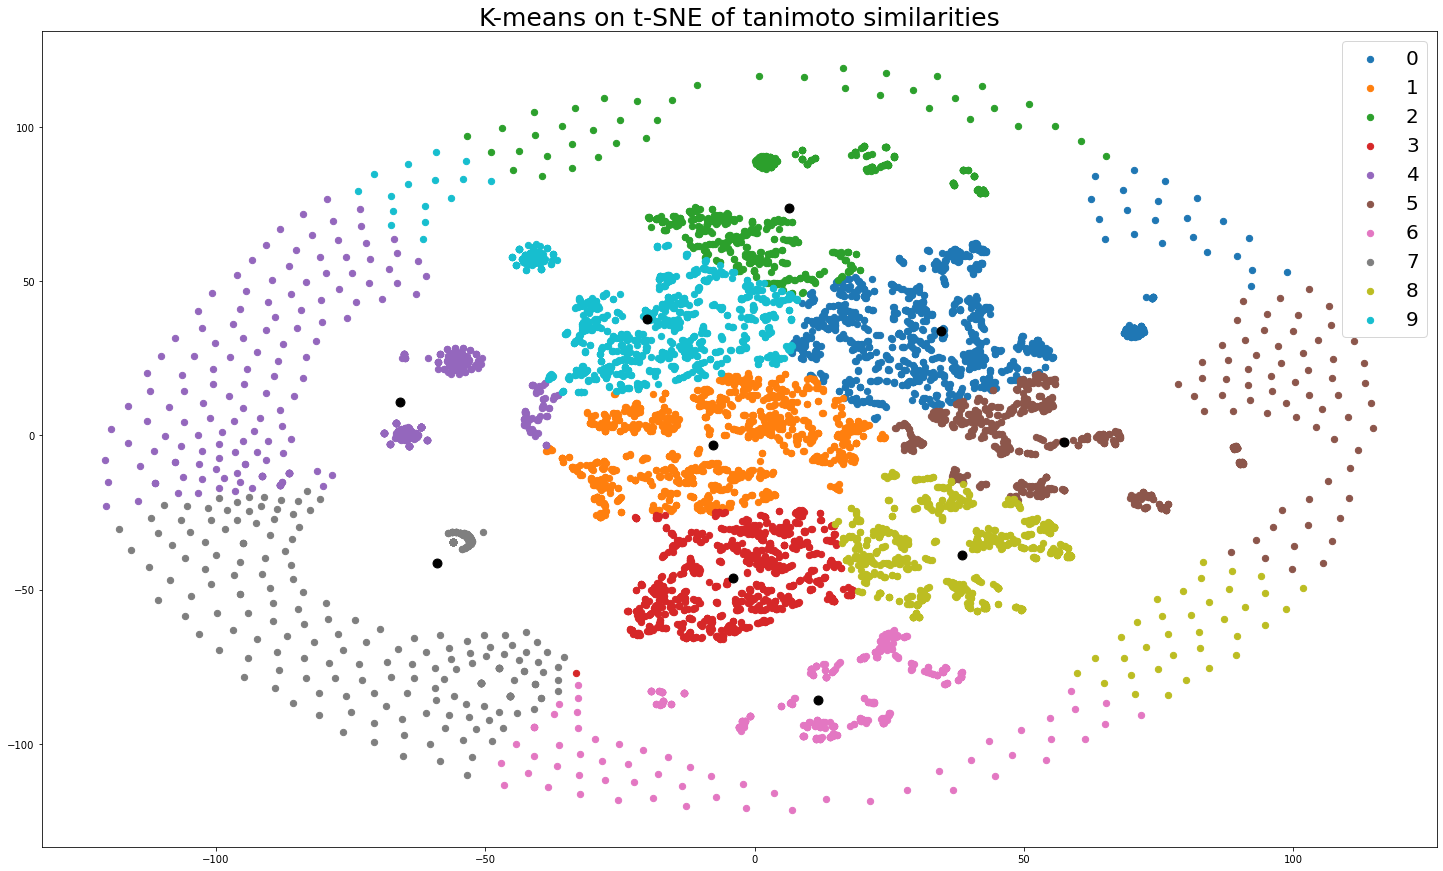

In [343]:
u_labels = np.unique(kmeans.labels_)
plt.subplots(1, figsize=(25, 15))
# plotting the results:
centroids = kmeans.cluster_centers_
for i in u_labels:
    plt.scatter(tsne_similarities[kmeans.labels_ == i, 0], tsne_similarities[kmeans.labels_ == i, 1], label=i, s=40)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')
plt.legend(prop={'size': 20})
plt.title("K-means on t-SNE of tanimoto similarities", fontsize=25)
plt.show()

In [344]:
print(kmeans.cluster_centers_)
print(kmeans.inertia_)
print(kmeans.inertia_)

[[ 34.61861    33.966698 ]
 [ -7.7150397  -2.9982057]
 [  6.309666   73.83974  ]
 [ -4.021977  -46.21121  ]
 [-65.85736    10.975989 ]
 [ 57.393482   -2.0067167]
 [ 11.7639885 -85.80217  ]
 [-58.946507  -41.261734 ]
 [ 38.467823  -38.894238 ]
 [-19.95002    37.65404  ]]
3956253.0
3956253.0


In [378]:
indexes_to_add = []
for i in range(10):
    d = kmeans.transform(tsne_similarities)[:, i]
    inds = np.argsort(d)[::][:760]
    for ind in inds:
        if ind not in indexes_to_add:
            indexes_to_add.append(ind)


In [379]:
len(np.unique(np.array(indexes_to_add)))

6989

In [380]:
len(np.array(indexes_to_add))

6989

In [381]:
undersampled_negative_dataset = new_negative_dataset.iloc[indexes_to_add,:]

In [382]:
bitter = pd.read_csv("clean_bitter_molecules.csv")
bitter

,ids,mols,y
0,265473,CCCCC1(CC)C(=O)NC(=O)NC1=O,0
1,265383,CCCCOC(=O)CCC(C)=O,0
2,265483,CCC1(CC)C(=O)NC(=O)NC1=O,0
3,265471,C=CCC1(CC=C)C(=O)NC(=O)NC1=O,0
4,265486,CC1(C2=CC=CC=C2)C(=O)NC(=O)NC1=O,0
...,...,...,...
1060,265288,NCC(=O)NC(CC1=CC=CC=C1)C(=O)O,0
1061,266883,N[C@@H](CC1=CC=CC=C1)C(=O)N[C@@H](CC1=CNC2=C1C...,0
1062,265286,NC(N)=NCCCC(NC(=O)C1CCCN1)C(=O)O,0
1063,291854,NC(CC1=CNC2=CC=CC=C12)C(=O)NC(CC1=CC=CC=C1)C(=O)O,0


In [383]:
bitter["y"] = [0]*bitter.shape[0]
final_negative_dataset = undersampled_negative_dataset.append(bitter)

In [384]:
df = pd.read_csv("clean_sweeteness_dataset_v3_1.csv")
positive_dataset = df[df["y"]==1]

In [385]:
final_binary_classification_dataset = positive_dataset.append(final_negative_dataset)


In [386]:
from copy import deepcopy

pre_processed_dataset = deepcopy(final_binary_classification_dataset)
indexes_to_remove = []
for j, row in final_binary_classification_dataset.iterrows():
    smiles = row["mols"]
    if len(smiles) < 6:
        indexes_to_remove.append(j)
        
pre_processed_dataset = pre_processed_dataset.drop(indexes_to_remove)
pre_processed_dataset.to_csv("preprocessed_sweeteners_dataset.csv", index=False)

In [101]:
import pandas as pd

sweeteners_dataset = pd.read_csv("preprocessed_sweeteners_dataset.csv")


In [102]:
sweeteners_dataset.shape

(16052, 3)

In [103]:
similarities = generate_similarities(sweeteners_dataset["mols"])

tsne_df = TSNE(n_components=2,random_state=123).fit_transform(similarities)
import matplotlib.pyplot as plt
import seaborn as sns

labels = sweeteners_dataset.loc[:,"y"]

string_labels = []
for label in labels:
    if label == 1:
        string_labels.append("Sweet")
    else:
        string_labels.append("Not Sweet")



/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


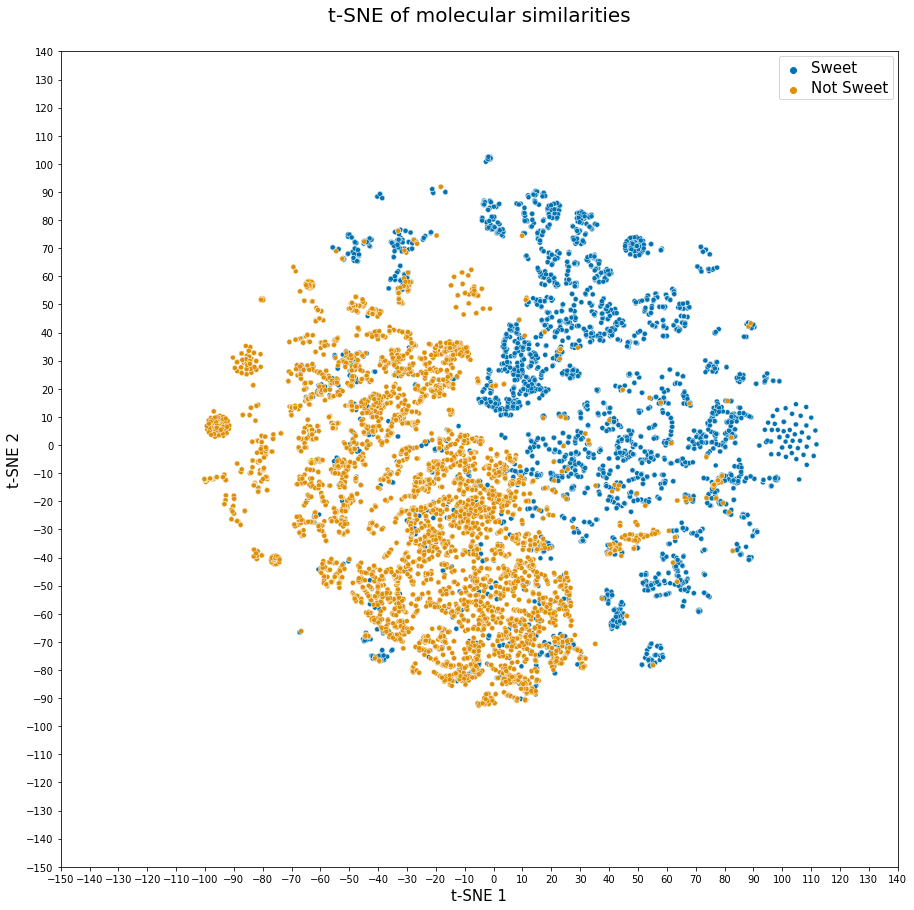

<Figure size 1080x1080 with 0 Axes>

In [104]:
fig, ax = plt.subplots()
plt.figure(figsize=(15, 15))
sns.scatterplot(
    tsne_df[:, 0], tsne_df[:, 1],
    hue=string_labels,
    palette=sns.color_palette("colorblind", 2),
    legend="full",
    s=25,
    ax=ax
)

ax.set_title("t-SNE of molecular similarities", 
                       fontdict= { 'fontsize': 20 }, pad= 30)

plt.setp(ax.get_legend().get_texts(), fontsize='15')
ax.set_xticks(range(-150,150,10))
ax.set_yticks(range(-150,150,10))
fig.set_size_inches(15,15)
ax.set_xlabel("t-SNE 1", fontsize='15')
ax.set_ylabel("t-SNE 2", fontsize='15')
plt.show()

In [148]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-110,0,10,110, 1)
len(cluster_molecules)

974

In [149]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-110,32,-110,10, 1)
len(cluster_molecules)

1565

In [152]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-110,0,10,110, 0)
len(cluster_molecules)

2495

In [153]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-110,32,-110,10, 0)
len(cluster_molecules)

5338

In [155]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,0,110,10,110, 1)
get_percentage_amino_acid(cluster_molecules)
#get_similarity("COC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(=O)O)N", cluster_molecules)

(0.6670757901196686, 2174, 3259)

In [156]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,0,110,10,110, 0)
get_percentage_amino_acid(cluster_molecules)

(0.6666666666666666, 22, 33)

In [150]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,32,110,-110,10, 1)
get_percentage_carbohydrate_monomer(cluster_molecules)

(0.9333635539437897, 2059, 2206)

In [154]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,32,110,-110,10, 0)
get_percentage_carbohydrate_monomer(cluster_molecules)

(0.9382022471910112, 167, 178)

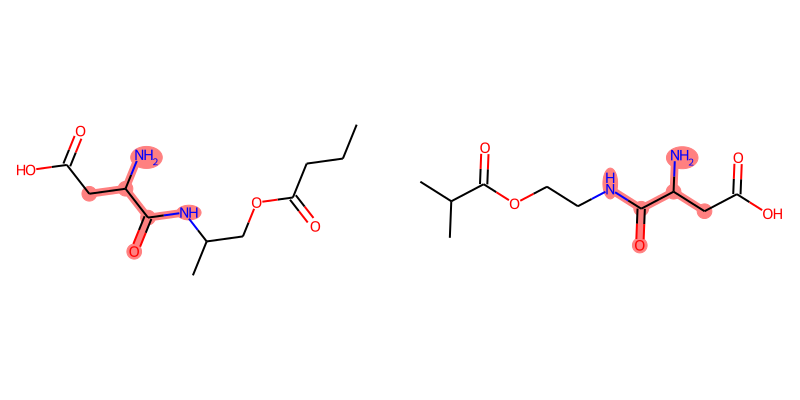

In [228]:
smarts = MolFromSmarts("[NX3,NX4+][CX4H]([*])[CX3](=[OX1])[O,N]")
to_highlight = highlight_atoms_with_query(cluster_molecules[3:5],smarts)
Draw.MolsToGridImage([MolFromSmiles(mol) for mol in cluster_molecules[3:5]],highlightAtomLists=to_highlight, molsPerRow=2, subImgSize=(400,400))

In [213]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-50,100,20,100, 1)
get_percentage_carbohydrate_monomer(cluster_molecules)

0.9809286898839138

In [225]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-50,100,20,100, 0)
get_percentage_carbohydrate_monomer(cluster_molecules)

0.1475295755045233

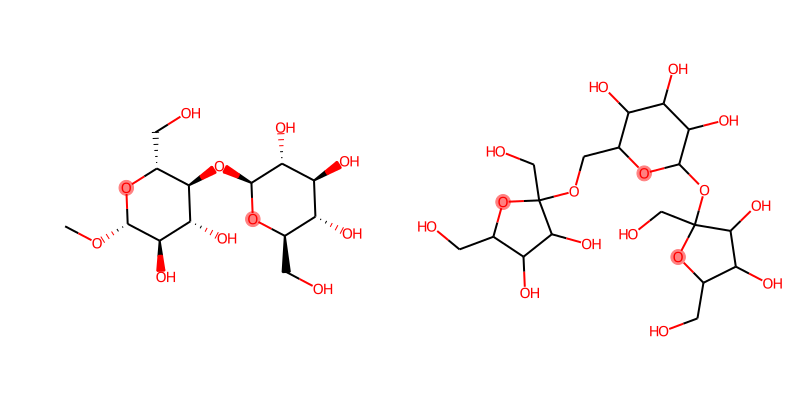

In [221]:
to_highlight = highlight_atoms_with_query(cluster_molecules[99:102],smarts)
Draw.MolsToGridImage([MolFromSmiles(mol) for mol in cluster_molecules[99:101]],highlightAtomLists=to_highlight, molsPerRow=2, subImgSize=(400,400))

In [112]:
def get_molecules_per_coordinates(df,sweeteners_dataset,x0,x1,y0,y1, class_label):
    
    cluster_molecules = []
    labels = sweeteners_dataset["y"]
    for i, coord in enumerate(df):
        if x0 < coord[0] < x1 and y0 < coord[1] < y1 and labels[i] == class_label:
            cluster_molecules.append(sweeteners_dataset.at[i,"mols"])
            
    return cluster_molecules

from rdkit import DataStructs

def get_similarity(query_seq, cluster_molecules):
    fps = []
    for mol in cluster_molecules:
        fp = AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(mol),2,nBits=2048)
        fps.append(fp)

    query_fp = \
    AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(query_seq),2,nBits=2048)

    scores = DataStructs.BulkTanimotoSimilarity(query_fp, fps)
    return np.mean(scores)

from rdkit.Chem import MolFromSmarts

def highlight_atoms_with_query(lst,smarts):
    to_highlight = []
    for mol in lst:
        mol = MolFromSmiles(mol)
        final_tuple = ()
        lst_idx = mol.GetSubstructMatches(smarts)
        for idx in lst_idx:
            final_tuple = final_tuple + idx


        to_highlight.append(final_tuple)
    return to_highlight

def get_percentage_carbohydrate_monomer(cluster_molecules):
    
    smarts = MolFromSmarts("[Or5,Or6,Or7,Or8]")
    counter = 0
    for mol in cluster_molecules:
        mol = MolFromSmiles(mol)
        isMonossacharide = mol.HasSubstructMatch(smarts)
        if isMonossacharide:
            counter+=1
    
    return counter/len(cluster_molecules), counter, len(cluster_molecules) 

def get_percentage_amino_acid(cluster_molecules):
    
    smarts = MolFromSmarts("[NX3,NX4+][CX4H]([*])[CX3](=[OX1])[O,N]")
    counter = 0
    for mol in cluster_molecules:
        mol = MolFromSmiles(mol)
        isPeptide = mol.HasSubstructMatch(smarts)
        if isPeptide:
            counter+=1
    
    return counter/len(cluster_molecules), counter, len(cluster_molecules) 


## Training set

In [55]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

train_sweeteners_dataset = pd.read_csv("stratified_split/stratified_split_train_dataset.csv")
train_similarities = generate_similarities(test_sweeteners_dataset["mols"])

train_tsne_df = TSNE(n_components=2,random_state=123).fit_transform(test_similarities)

/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


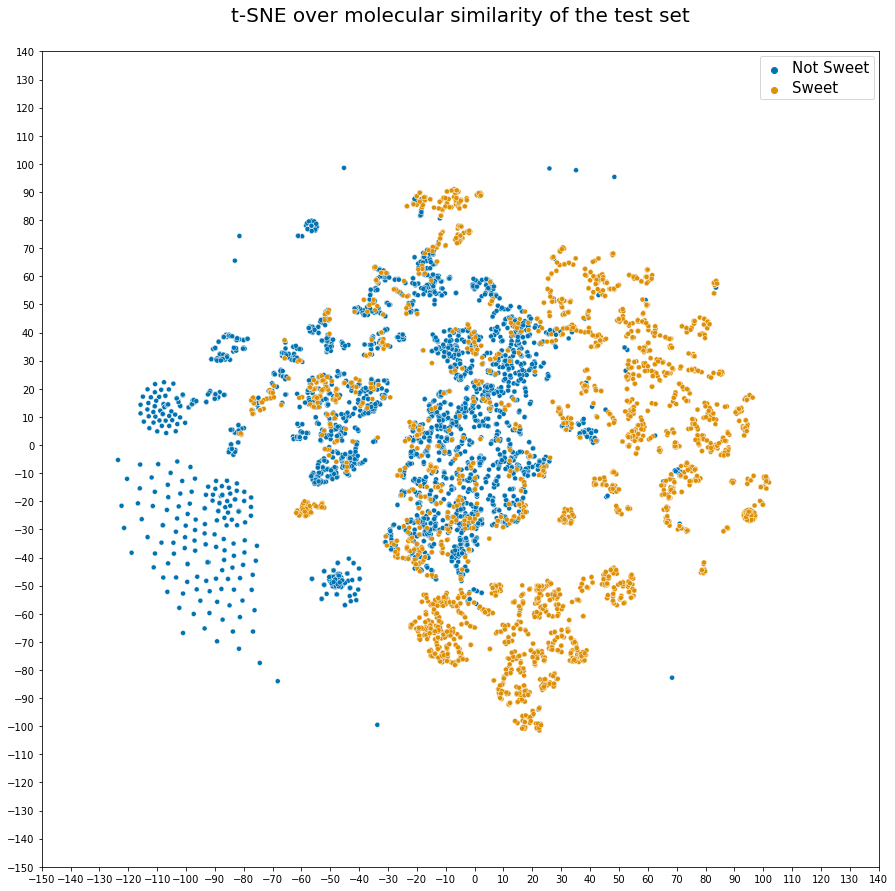

<Figure size 1080x1080 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = train_sweeteners_dataset.loc[:,"y"]
string_labels = []
for label in labels:
    if label == 1:
        string_labels.append("Sweet")
    else:
        string_labels.append("Not Sweet")
    
fig, ax = plt.subplots()
plt.figure(figsize=(15, 15))
scatter_plot = sns.scatterplot(
    train_tsne_df[:, 0], train_tsne_df[:, 1],
    hue=string_labels,
    palette=sns.color_palette("colorblind", 2),
    legend="full",
    s=25,
    ax=ax
)
ax.set_title("t-SNE over molecular similarity of the test set", 
                       fontdict= { 'fontsize': 20 }, pad= 30)

plt.setp(ax.get_legend().get_texts(), fontsize='15')
ax.set_xticks(range(-150,150,10))
ax.set_yticks(range(-150,150,10))
fig.set_size_inches(15,15)
plt.show()

## Test set

In [97]:
df = pd.read_csv("stratified_split/stratified_split_test_dataset.csv")
df_train = pd.read_csv("stratified_split/stratified_split_train_dataset.csv")

train_smiles = df_train.mols.values
not_isomeric_train = []
for smile in train_smiles:
    mol = MolFromSmiles(smile)
    smiles = MolToSmiles(mol, isomericSmiles=False)
    if smiles not in not_isomeric:
        not_isomeric_train.append(smiles)

not_isomeric = []
isomeric = []
for smile in df.mols.values:
    mol = MolFromSmiles(smile)
    smiles = MolToSmiles(mol, isomericSmiles=False)
    if smiles not in not_isomeric and smiles not in not_isomeric_train:
        not_isomeric.append(smiles)
        isomeric.append(smile)

In [85]:
len(isomeric)

5817

In [98]:
df_test_set = df[df["mols"].isin(isomeric)].drop_duplicates(subset=["mols"])
print(df_test_set[df_test_set["y"] == 1].shape)
print(df_test_set[df_test_set["y"] == 0].shape)

sweeteners_test_set = df_test_set[df_test_set["y"] == 1].mols
non_sweeteners_test_set = df_test_set[df_test_set["y"] == 0].mols
np.random.seed_value = 123
non_sweeteners_test_set = list(np.random.choice(non_sweeteners_test_set, len(sweeteners_test_set), replace=False))

df1 = DataFrame(columns=["mols","y"])
df1["mols"] = sweeteners_test_set
df1["y"] = [1] * len(sweeteners_test_set)
df2 = DataFrame(columns=["mols","y"])
df2["mols"] = non_sweeteners_test_set
df2["y"] = [0] * len(non_sweeteners_test_set)

df = df1.append(df2)
df.to_csv("non_isomeric_test_set.csv", index=True)

(2124, 3)
(3693, 3)


In [99]:
pd.read_csv("non_isomeric_test_set.csv")

,Unnamed: 0,mols,y
0,4020,CCCCCCCCOCC1(OC2OC(CO)C(O)C(O)C2O)OC(CO)C(OCCC...,1
1,4021,CC(O)(O)C(O)C(O)C(O)CO,1
2,4023,CNC(=O)C(CC1=CC=CC=C1)NC(=O)C(N)CC(=O)O,1
3,4024,OCCC(O)CC(O)C(O)CO,1
4,4025,CCCCCCCCOCC1(OC2OC(CO)C(O)C(O)C2O)OC(CO)C(O)C1O,1
...,...,...,...
4243,2119,CCC(=O)C(C)C(=O)O,0
4244,2120,O=C1NC(CC2=CC=CC=C2)=NC2=CC=CC=C12,0
4245,2121,C[C@@H](N)[C@@H](O)C1=CC=CC=C1,0
4246,2122,CCCCCOC(=O)C(C)CC,0


In [58]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

test_sweeteners_dataset = pd.read_csv("stratified_split/stratified_split_test_dataset.csv")
test_similarities = generate_similarities(test_sweeteners_dataset["mols"])

test_tsne_df = TSNE(n_components=2,random_state=123).fit_transform(test_similarities)

/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


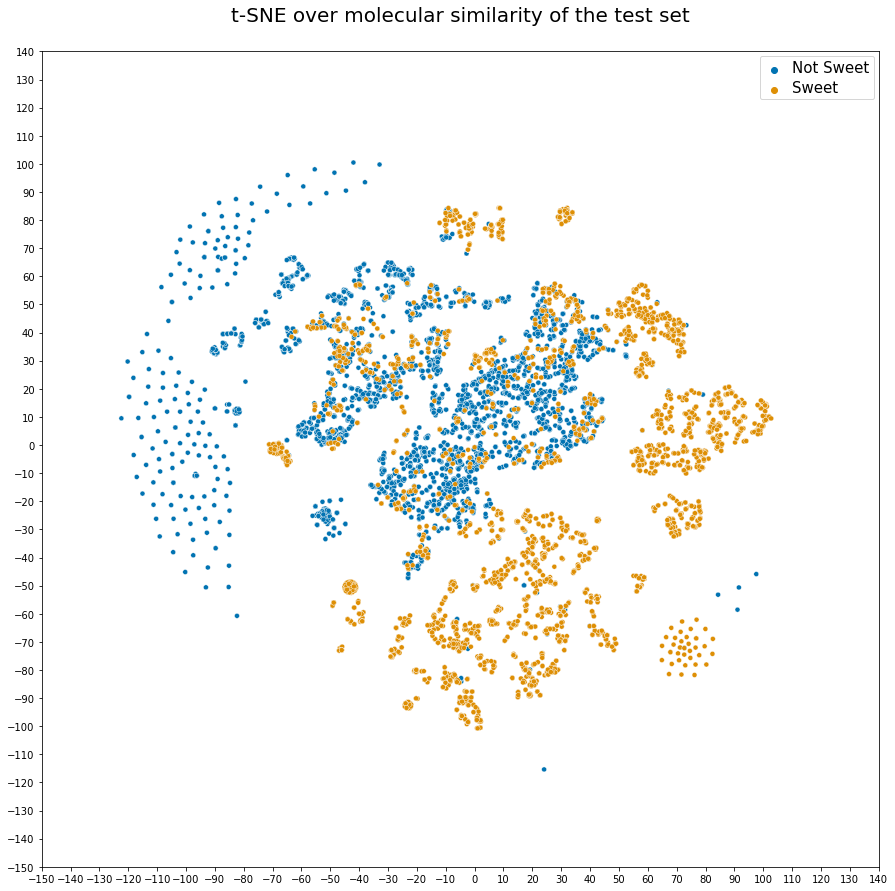

<Figure size 1080x1080 with 0 Axes>

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = test_sweeteners_dataset.loc[:,"y"]
string_labels = []
for label in labels:
    if label == 1:
        string_labels.append("Sweet")
    else:
        string_labels.append("Not Sweet")
    
fig, ax = plt.subplots()
plt.figure(figsize=(15, 15))
scatter_plot = sns.scatterplot(
    test_tsne_df[:, 0], test_tsne_df[:, 1],
    hue=string_labels,
    palette=sns.color_palette("colorblind", 2),
    legend="full",
    s=25,
    ax=ax
)
ax.set_title("t-SNE over molecular similarity of the test set", 
                       fontdict= { 'fontsize': 20 }, pad= 30)

plt.setp(ax.get_legend().get_texts(), fontsize='15')
ax.set_xticks(range(-150,150,10))
ax.set_yticks(range(-150,150,10))
fig.set_size_inches(15,15)
plt.show()

In [157]:
sweeteners_blend_test_set = get_molecules_per_coordinates(test_tsne_df,test_sweeteners_dataset,-80,50,-50,80, 1)
len(sweeteners_blend_test_set)

1441

In [158]:
non_sweeteners_blend_test_set = get_molecules_per_coordinates(test_tsne_df,test_sweeteners_dataset,-80,50,-50,80, 0)
len(non_sweeteners_blend_test_set)
np.random.seed_value = 123
non_sweeteners_blend_test_set = list(np.random.choice(non_sweeteners_blend_test_set, 1441, replace=False))

In [159]:
from pandas import DataFrame

df1 = DataFrame(columns=["smiles","y"])
df1["smiles"] = sweeteners_blend_test_set
df1["y"] = [1] * len(sweeteners_blend_test_set)
df2 = DataFrame(columns=["smiles","y"])
df2["smiles"] = non_sweeteners_blend_test_set
df2["y"] = [0] * len(non_sweeteners_blend_test_set)

df = df1.append(df2)
df.to_csv("blend_test_set.csv", index=True)

In [160]:
import pandas as pd
from rdkit.Chem import MolFromSmiles, MolToSmiles

df = pd.read_csv("blend_test_set.csv")
df_train = pd.read_csv("stratified_split/stratified_split_train_dataset.csv")

train_smiles = df_train.mols.values
not_isomeric_train = []
for smile in train_smiles:
    mol = MolFromSmiles(smile)
    smiles = MolToSmiles(mol, isomericSmiles=False)
    if smiles not in not_isomeric:
        not_isomeric_train.append(smiles)

not_isomeric = []
isomeric = []
for smile in df.smiles.values:
    mol = MolFromSmiles(smile)
    smiles = MolToSmiles(mol, isomericSmiles=False)
    if smiles not in not_isomeric and smiles not in not_isomeric_train:
        not_isomeric.append(smiles)
        isomeric.append(smile)

In [66]:
df.drop_duplicates(subset=["smiles"])

,Unnamed: 0,smiles,y
0,0,CC(O)(O)C(O)C(O)C(O)CO,1
1,1,OCCC(O)CC(O)C(O)CO,1
2,2,OCCC(O)CCC(O)CO,1
3,3,OCC(O)CC(O)CC(O)CO,1
4,4,O=CC(=O)C(O)C(O)C(O)C(O)C(O)C(O)C(O)C(O)C(O)C=O,1
...,...,...,...
2877,1436,O=C(O)C1=CC2=CC=CC=C2O1,0
2878,1437,CC(=S)NC1=CC=CC=C1,0
2879,1438,CC#CC#CC#CC(=O)O,0
2880,1439,COC1=CC=C(C2=CC(=O)C3=C(OC)C(OC)=C(OC)C=C3O2)C...,0


In [68]:
df.drop_duplicates(subset=["smiles"])

,Unnamed: 0,smiles,y
0,0,CC(O)(O)C(O)C(O)C(O)CO,1
1,1,OCCC(O)CC(O)C(O)CO,1
2,2,OCCC(O)CCC(O)CO,1
3,3,OCC(O)CC(O)CC(O)CO,1
4,4,O=CC(=O)C(O)C(O)C(O)C(O)C(O)C(O)C(O)C(O)C(O)C=O,1
...,...,...,...
2877,1436,O=C(O)C1=CC2=CC=CC=C2O1,0
2878,1437,CC(=S)NC1=CC=CC=C1,0
2879,1438,CC#CC#CC#CC(=O)O,0
2880,1439,COC1=CC=C(C2=CC(=O)C3=C(OC)C(OC)=C(OC)C=C3O2)C...,0


In [161]:
df_blend_set = df[df["smiles"].isin(isomeric)].drop_duplicates(subset=["smiles"])
print(df_blend_set[df_blend_set["y"] == 1].shape)
print(df_blend_set[df_blend_set["y"] == 0].shape)

(883, 3)
(1333, 3)


In [162]:
sweeteners_blend_test_set = df_blend_set[df_blend_set["y"] == 1].smiles
non_sweeteners_blend_test_set = df_blend_set[df_blend_set["y"] == 0].smiles
np.random.seed_value = 123
non_sweeteners_blend_test_set = list(np.random.choice(non_sweeteners_blend_test_set, df_blend_set[df_blend_set["y"] == 1].shape[0], replace=False))

df1 = DataFrame(columns=["smiles","y"])
df1["smiles"] = sweeteners_blend_test_set
df1["y"] = [1] * len(sweeteners_blend_test_set)
df2 = DataFrame(columns=["smiles","y"])
df2["smiles"] = non_sweeteners_blend_test_set
df2["y"] = [0] * len(non_sweeteners_blend_test_set)

df = df1.append(df2)
df.to_csv("non_isomeric_blend_test_set.csv", index=True)

In [163]:
df = pd.read_csv("non_isomeric_blend_test_set.csv")
df

,Unnamed: 0,smiles,y
0,0,CC(O)(O)C(O)C(O)C(O)CO,1
1,1,OCCC(O)CC(O)C(O)CO,1
2,2,OCCC(O)CCC(O)CO,1
3,4,O=CC(=O)C(O)C(O)C(O)C(O)C(O)C(O)C(O)C(O)C(O)C=O,1
4,5,CC1OC(OF)CC(O)C1O,1
...,...,...,...
1761,878,CCCCCCCCC/C=C/CO,0
1762,879,NS(=O)(=O)CC1=NOC2=CC=CC=C21,0
1763,880,CCN(CC)CCCN1S(=O)(=O)C2=CC=CC=C2S1(=O)=O,0
1764,881,CCN(CC)C(=O)CSC1=CC=C(Cl)N=N1,0


In [400]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-60,40,-40,-20, 1)
get_percentage_carbohydrate_monomer(cluster_molecules)

KeyError: 8261

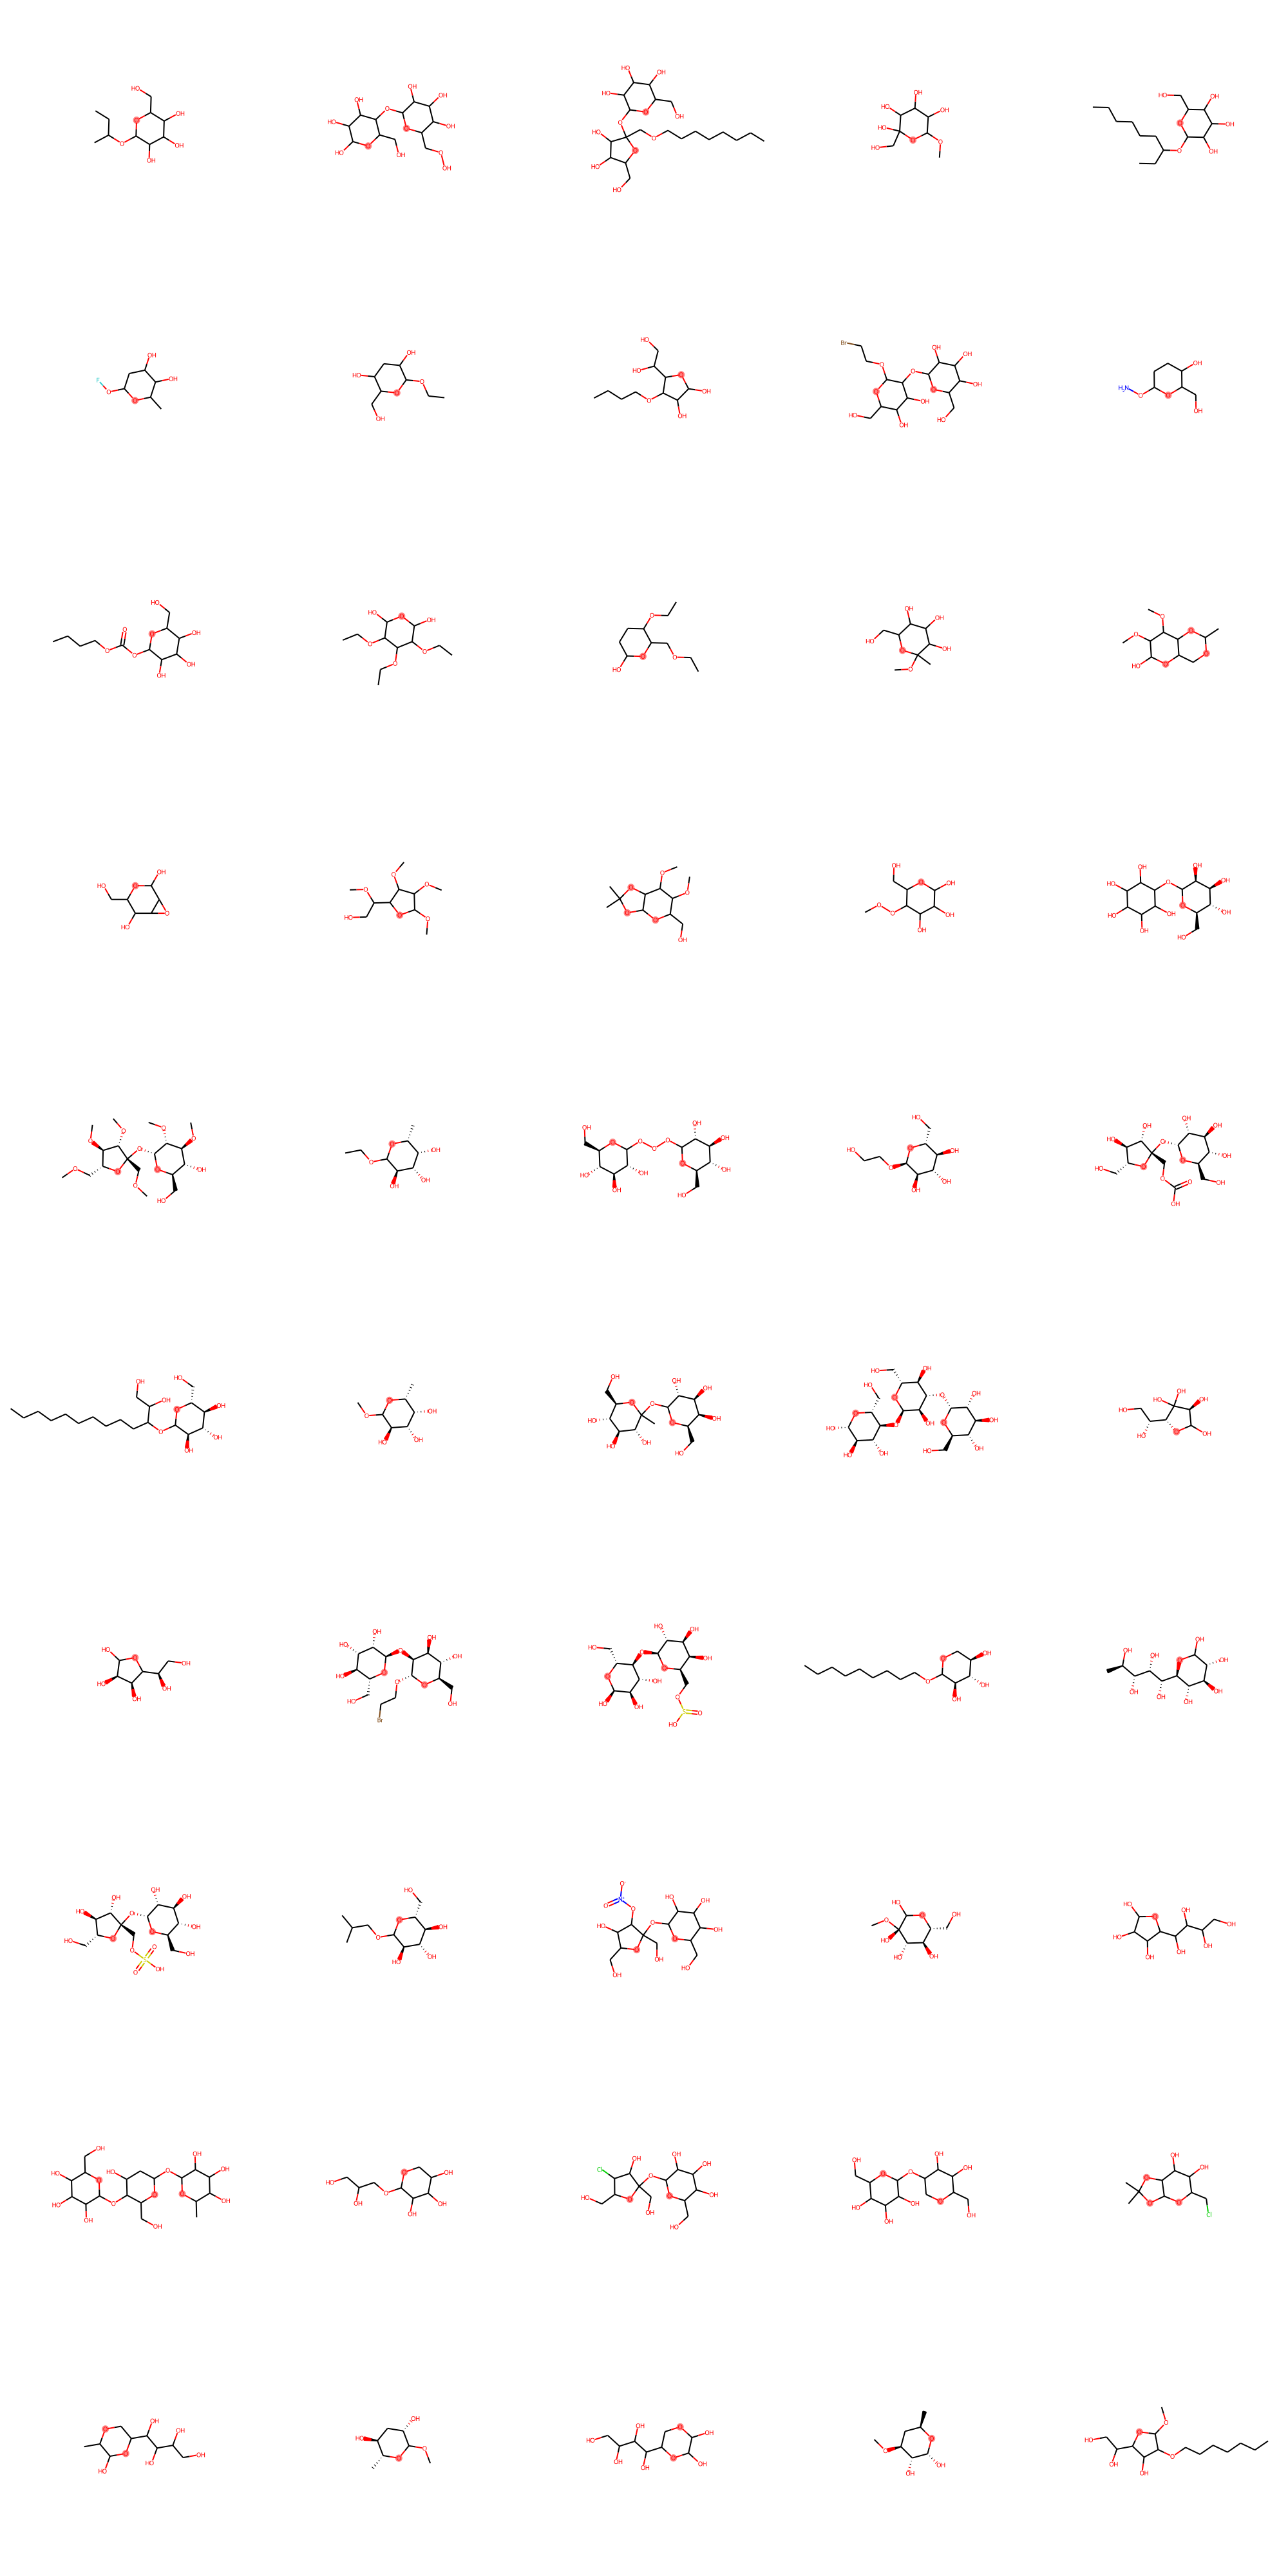

In [195]:
from rdkit.Chem import Draw

smarts = MolFromSmarts("[Or5,Or6,Or7,Or8]")
to_highlight = highlight_atoms_with_query(cluster_molecules,smarts)
Draw.MolsToGridImage([MolFromSmiles(mol) for mol in cluster_molecules],highlightAtomLists=to_highlight, molsPerRow=5, subImgSize=(400,400))

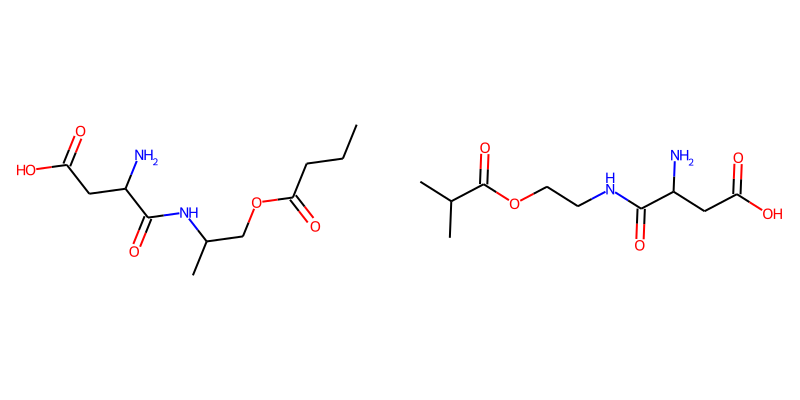

In [210]:
to_highlight = highlight_atoms_with_query(cluster_molecules[3:5],smarts)
Draw.MolsToGridImage([MolFromSmiles(mol) for mol in cluster_molecules[3:5]],highlightAtomLists=to_highlight, molsPerRow=2, subImgSize=(400,400))

In [152]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,20,90,-40,20, 1)
get_percentage_amino_acid(cluster_molecules)

0.972636815920398

In [178]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-10,20,20,30, 1)
#get_percentage_amino_acid(cluster_molecules)
get_similarity("C([C@H]([C@H]([C@@H]([C@H](CO)O)O)O)O)O", cluster_molecules)
get_similarity("O=CC(O)C(O)C(O)C(O)CO",cluster_molecules)

0.2557006929471862

In [179]:
cluster_molecules

['OCCC(O)CCC(O)CO',
 'OCCC(O)CC(O)C(O)CO',
 'CC(O)(O)C(O)C(O)C(O)CO',
 'OCC(O)C(O)C(O)C(O)C=[Se]',
 'CCOC(=O)CC1NC(=O)C(CC2=CC=CC=C2)NC1=O',
 'CC(O)C(O)(O)C(O)C(O)CO',
 'CC(O)C(O)CCO',
 'OC[C@@H](O)CC(O)C[C@H](O)CO',
 'OCC(O)C(O)C(O)C(O)C(O)F',
 'CC(O)(O)C(O)C(O)CO',
 'OCCC(O)C(O)C(O)O',
 'O=C(O)CC1=CC=CC=C1',
 'CC(=O)OCCC1=CC=CC=C1',
 'O=C(CC1=CC=CC=C1)OCC1=CC=CC=C1',
 'COC(=O)C1=CC=CO1',
 'CC(O)C(O)C(O)CO',
 'OCCC(O)C(O)CO',
 'C[C@H](O)[C@@H](O)[C@@H](O)[C@H](O)CO',
 'C[C@H](O)[C@H](O)[C@H](O)CO',
 'OCC[C@@H](O)[C@@H](O)[C@H](O)CO',
 'C[C@@H](O)[C@@H](O)[C@H](O)CCO',
 'C=CCOC(=O)CC1=CC=CC=C1',
 'O=C(CC1=CC=CC=C1)OCCC1=CC=CC=C1',
 'O=C(OCC1=CC=CC=C1)C1=CC=CC=C1O',
 'OC[C@@H](O)[C@@H](O)[C@H](F)[C@H](O)CO',
 'C[C@H](O)[C@@H](O)[C@H](O)CO',
 'OCC[C@H](O)[C@H](O)CO',
 'COC(=O)CC1NC(=O)C(CC2=CC=CC=C2)NC1=O',
 'OCCC(O)C(O)C(O)CO',
 'C[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO',
 'OCCCC[C@H](O)CO',
 'CC(C)(C)OC(=O)C[C@@H]1NCCN([C@@H](CC2=CC=CC=C2)C(=O)OC(C)(C)C)C1=O',
 'OCCC(O)C(O)CCO',
 'C[C@@H]

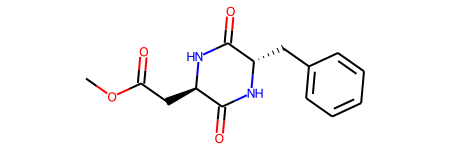

In [182]:
MolFromSmiles("COC(=O)C[C@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC1=O")

In [44]:
cluster_size = 0
for i, coord in enumerate(tsne_df):
    if -60 < coord[0] < 70 and 0 > coord[1] > -100 and labels[i] == 1:
        cluster_size+=1
        print(sweeteners_dataset.at[i,"mols"])
        
cluster_size 

OCC1OC(O)C(O)C(O)C1OC1OC(COO)C(O)C(O)C1O
COC1OC(O)(CO)C(O)C(O)C1O
CCOC1OC(CO)C(O)CC1O
OCC1OC(OC2C(OCCBr)OC(CO)C(O)C2O)C(O)C(O)C1O
NOC1CCC(O)C(CO)O1
CCOC1C(O)OC(O)C(OCC)C1OCC
CCOCC1OC(O)CCC1OCC
COC1(C)OC(CO)C(O)C(O)C1O
OCC1OC(O)C2OC2C1O
COC(CO)C1OC(OC)C(OC)C1OC
COC1C(CO)OC2OC(C)(C)OC2C1OC
COOC1C(CO)OC(O)C(O)C1O
OC[C@H]1OC(OC2C(O)C(O)C(O)C(O)C2O)[C@@H](O)[C@@H](O)[C@@H]1O
COC[C@H]1O[C@@](COC)(O[C@H]2O[C@H](CO)[C@@H](O)[C@H](OC)[C@H]2OC)[C@@H](OC)[C@@H]1OC
CCOC1O[C@H](C)[C@H](O)[C@H](O)[C@H]1O
OC[C@H]1OC(OOOC2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@@H]1O
OCCO[C@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
O=C(O)OC[C@@]1(O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O
CC1(OC2O[C@H](CO)[C@H](O)[C@H](O)[C@H]2O)O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
OC[C@@H](O)[C@H]1OC(O)[C@H](O)C1(O)O
OC[C@@H](O)C1OC(O)[C@H](O)[C@@H]1O
OC[C@H]1O[C@H](OCCBr)[C@@H](O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]2O)[C@@H](O)[C@@H]1O
O=S(O)OC[C@H]1O[C@@H](O[C@@H]2[C@@H](CO)O[C@H](O)[C@H](O)[C@

1162

In [133]:
cluster_size = 0
cluster_molecules = []
for i, coord in enumerate(tsne_df):
    if -25 < coord[1] < 50 and 30 > coord[0] > -70 and labels[i] == 1:
        cluster_size+=1
        cluster_molecules.append(sweeteners_dataset.at[i,"mols"])
        
cluster_size

1141

In [138]:
cluster_size = 0
cluster_molecules = []
for i, coord in enumerate(tsne_df):
    if -25 < coord[1] < 50 and 30 > coord[0] > -70 and labels[i] == 0:
        cluster_size+=1
        cluster_molecules.append(sweeteners_dataset.at[i,"mols"])
        #print(sweeteners_dataset.at[i,"mols"])
        
cluster_size

1970